<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S5/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [ ]:
! pip install pytreebank

  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp37-none-any.whl size=37070 sha256=20486e4e06a4623184c550b8097ecb9f7e838881f4b755b95ce92dce7b226d1a
  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c726e270b9a29f2368
Successfully built pytreebank


In [ ]:
! git clone https://github.com/namanphy/END2.git

Cloning into 'END2'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 201 (delta 83), reused 151 (delta 51), pack-reused 0
Receiving objects: 100% (201/201), 6.81 MiB | 7.19 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [ ]:
cd /content/END2/S5

/content/END2/S5


In [ ]:
! unzip /content/END2/S5/stanfordSentimentTreebank.zip 

unzip:  cannot find or open /content/END2/S5/stanfordSentimentTreebank.zip, /content/END2/S5/stanfordSentimentTreebank.zip.zip or /content/END2/S5/stanfordSentimentTreebank.zip.ZIP.


In [ ]:
ls

data/  exp/  model/  trainer/  utils.py


In [ ]:
import pandas as pd
from data import sentences_to_dataframe

# Manual Seed
SEED = 45
torch.manual_seed(SEED)



---



# Generating train and test sentence-label dataframes
From raw txt files..

In [ ]:
df_train, df_test = sentences_to_dataframe(path_sst='/content/END2/S5/data/stanfordSentimentTreebank', seed=SEED)

Adding 940 more rows to trainset.


/content/END2/S5/data/sst_dataset.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv(out_path.format('train'), sep='\t\t', header=None, names=['label', 'text'])
/content/END2/S5/data/sst_dataset.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  for f in ['test', 'dev']), ignore_index=True)


In [ ]:
print(df_train.shape)
print(df_test.shape)
df_train.head(2)

(9484, 2)
(2371, 3)


,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...


# Using Back-Translation - Google Trans

In [ ]:
!pip install googletrans==3.1.0a0

#### Selecting random sample from the training data.

**Note: Here only 5% of the data of training set is picked due to API limitations.**

In [ ]:
import random
import googletrans
translator = googletrans.Translator()

# Selecting random sample - Picking 5% of the training data - API has limits
df_sample1 = df_train.sample(int(df_train.shape[0]*0.05))

#### Translating

In [ ]:
aug_data_translate = {'label': [], 'text': []}
for ix, (label_field, text_field) in df_sample1.iterrows():
    sentence = [text_field]

    available_langs = list(googletrans.LANGUAGES.keys()) 
    trans_lang = random.choice(available_langs) 
    print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

    translations = translator.translate(sentence, dest=trans_lang)
    t_text = [t.text for t in translations]
    print(t_text)

    translations_en_random = translator.translate(t_text, src=trans_lang, dest='en') 
    en_text = [t.text for t in translations_en_random]
    print(en_text)

    aug_data_translate['label'].append(label_field)
    aug_data_translate['text'].append(en_text)

["It 's consistently funny , in an irresistible junior-high way , and consistently free of any gag that would force you to give it a millisecond of thought ."]
Translating to dutch
['Het is altijd grappig, op een onweerstaanbare middelbare school en consequent vrij van elke grap die je zou dwingen er een milliseconde over na te denken.']
["It's always funny, in an irresistible high school, and consistently free of any joke that would force you to think about it for a millisecond."]
['A muddy psychological thriller rife with miscalculations .']
Translating to mongolian
['Буруу тооцоотой, шаварлаг сэтгэлзүйн триллер.']
['Miscalculated, muddy psychological thriller.']
['LaBute masterfully balances both Traditional or Modern stories together in a manner that one never overwhelms the other .']
Translating to javanese
['LaBute bisa ngimbangi crita-crita Tradhisional utawa Modern kanthi trampil kanthi cara sing ora nate ngalahake liyane.']
['LaBute is able to balance Traditional or Modern sto

#### Checking data length and converting back to datafram

In [ ]:
assert len(aug_data_translate['label']) == len(aug_data_translate['text']), "Some error occured. Size Mismatch!"
len(aug_data_translate['text'])

474

In [ ]:
df_translate = pd.DataFrame.from_dict(aug_data_translate)
df_translate['text'] = df_translate['text'].apply(lambda x: x[0] )
df_translate.head()

,label,text
0,4,"It's always funny, in an irresistible high sch..."
1,2,"Miscalculated, muddy psychological thriller."
2,5,LaBute is able to balance Traditional or Moder...
3,1,"For a depressing story, this is a heart-wrench..."
4,3,"Few of the increasingly attracted events, foll..."


#### Saving the dataframe to csv

In [ ]:
df_translate.to_csv("back_translate_5percent.csv", index=False)

# Random Swap and Random Delete

#### Using nlpaug library for data augmentation

In [ ]:
! pip install nlpaug

In [ ]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

**Selecting the probability of 20% of words to be changed for each sentence.**

From the reference of the following image. Taken from paper - [link](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip)



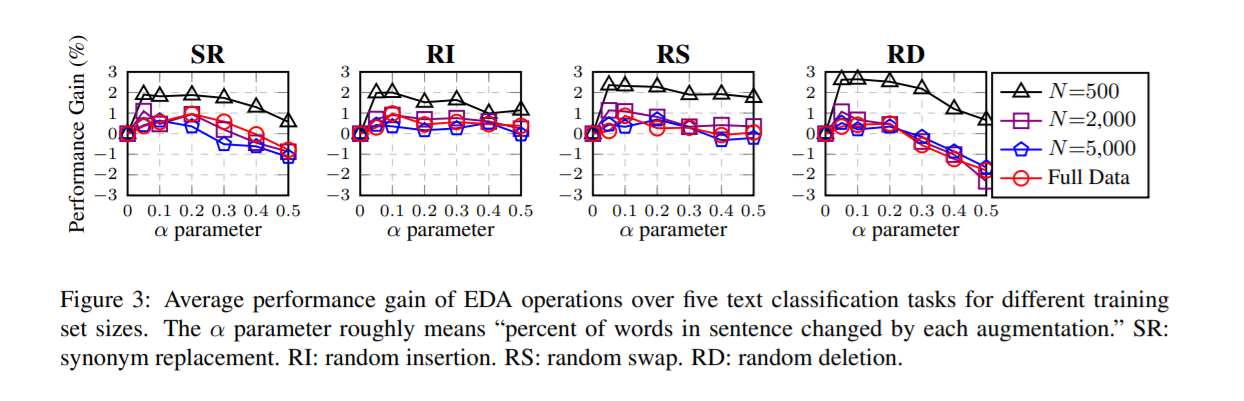

In [ ]:
random_swap = naw.RandomWordAug(action="swap", aug_p=20, aug_min=2, aug_max=10)
random_delete = naw.RandomWordAug(action="delete", aug_p=20, aug_min=2, aug_max=10)

#### Two different sub samples from the training data.

In [ ]:
df_sample1 = df_train.sample(int(df_train.shape[0]/4))
df_sample2 = df_train.sample(int(df_train.shape[0]/4))

In [ ]:
print(df_sample1.shape), print(df_sample2.shape)

(2371, 2)
(2371, 2)


(None, None)

#### Doing the work

In [ ]:
aug_data_swap = {'label': [], 'text': []}
aug_data_delete = {'label': [], 'text': []}

for ix, (label_field, text_field) in df_sample1.iterrows():
    aug_data_swap['text'].append(random_swap.augment(text_field))
    aug_data_swap['label'].append(label_field)

for ix, (label_field, text_field) in df_sample2.iterrows():
    # print(text_field)
    # print(label_field)
    aug_data_delete['text'].append(random_delete.augment(text_field))
    aug_data_delete['label'].append(label_field)

#### Checking and saving to CSV

In [ ]:
assert len(aug_data_swap['label']) == len(aug_data_swap['text']), "Some error occured. Size Mismatch!"
print(len(aug_data_swap['text']))

assert len(aug_data_delete['label']) == len(aug_data_delete['text']), "Some error occured. Size Mismatch!"
len(aug_data_delete['text'])

2371


2371

In [ ]:
df_swap = pd.DataFrame.from_dict(aug_data_swap)
df_swap.to_csv("random_swap_25percent.csv", index=False)
df_swap.head()

,label,text
0,1,Is story the and its - bogus characters thin t...
1,4,It never it makes quite the to boiling point b...
2,2,() Newton through wanders CHARLIE completely n...
3,5,' it s the kind effectively of creepy - scary ...
4,4,"Diaz, Applegate, and Blair Posey suitably are ..."


In [ ]:
df_delete = pd.DataFrame.from_dict(aug_data_delete)
df_delete.to_csv("random_delete_25percent.csv", index=False)
df_delete.head()

,label,text
0,2,Its thorn (and simple humanity) plundered by s...
1,4,( Scherfig) made will you wondering about the ...
2,2,Diane Lane ' performance n ' t Adrian ' from.
3,4,"Terry is sort of geriatric, which will Eastwoo..."
4,3,"Empty, - and - street credibility."
